# Convection-Diffusion in 1D

ME469 - Computational Methods in Fluid Dynamics - Stanford University

Example #3

These examples are provided as part of the ME469 class (Spring 2018).

For comments or corrections, please contact jops at stanford dot edu

## Objective
Study the convergence rate of the solution to the linear convection-diffusion equation using different finite volume schemes 

We wish to solve the transport of a contaminant $\phi$ in a closed space. The mathematical model chosen is 1D linear convection/diffusion equation using explicit finite difference schemes

$$\int_S \left( \vec{v} \cdot \vec{n} \right) \phi dS   = \int_S \gamma \left( \vec{\nabla}\phi \cdot \vec{n}  \right) dS $$

$\phi(x)$ is a scalar quantity (i.e. the concentration of a pollutant - defined in parts-per-million). We seek a solution using different numerical discretization on a 1D domain $S$, with imposed values of $\phi$ at the left ($x=0$) and right ($x=L$) boundaries. The convection velocity $\vec{v}$ is simply $u$ ($u>0$) in 1D, and $\gamma$ is the diffusion coefficient.

Let's first define the exact solution, which is simply 

$$ \frac{ \phi(x)-\phi_0}{\phi_L-\phi_0} = \frac{exp (Pe\cdot x/L) - 1}{exp (Pe) -1} $$

where  $\phi_0$ and $\phi_L$ are the boundary values, and $Pe=uL/\gamma$ is the Peclet number (or Reynolds number) that controls the relative importance of convection and diffusion.

The numerical solution is defined as $\phi(x,t) \approx \phi(x_i,t^n)= \phi^n_i$ on  a grid consisting of $nno$ control volumes. $x_0$ and $x_{nno}$ are the left and right boundariy locations,  while $x_1,x_2,\cdots,x_{nno-1}$ are the internal nodes. $xc_0, xc_1, \cdots, x_{ncv-1}$ are the centroids of the $ncv$ control volumes.

In [42]:
#set things up
import numpy  as np                       
import pylab as pl
import time, sys  
%matplotlib inline 

### Let's get started
Set physical and numerical parameters for the problem, and define a suitable initiation condition

In [43]:
u = 1         # convection speed [m/s]
gamma = 0.1     # diffusion coefficient [m^2/s]
L = 1.0         # length of the domain (in x) [m]
phi0 = 0    # value at x=0
phiL = 1    # value at x=1

peclet = u*L/gamma 
print "Peclet Number = ",peclet

Peclet Number =  10.0


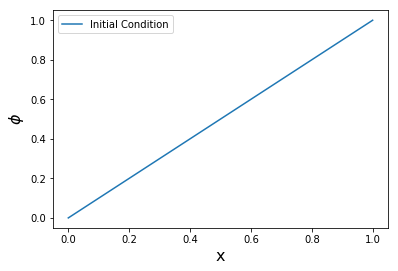

In [44]:
# define initial condition   
def ic(x):
    # initial distribution is linear 
    phi_ic = phi0 + x*(phiL-phi0)/L
    return phi_ic

# plot the initial condition to check that is what you expect...
def ic_plot():
    x = np.linspace(0,L,100)
    phi = np.zeros(100)  
    for i in range(100):
        phi[i]=ic(x[i])
    pl.clf()
    # make sure axis have labels and you include a legend
    pl.plot(x,phi, '-',label='Initial Condition')
    pl.legend()
    pl.xlabel("x",fontsize=16)  
    pl.ylabel(r"$\phi $",fontsize=16)
   
ic_plot()

Some utility functions that will be useful later

In [45]:
# set initial condition   
def initialize(ncv,xc,phi):
    for icv in range(ncv):
        phi[icv]=0.0
       # phi[icv]=ic(xc[icv])

# generate the grid
def generate_grid(ncv,x,xc):
    nno = ncv+1        # number of nodes
    dx = L / ncv    # spacing of the nodes
    #x = np.linspace(0,L,nno)  #grid generation!
    #xc = np.zeros(ncv)   # control volume centroid
    expansion = 0.99 # expansion = 1 gives a unifrom mesh
    if expansion==1.0:
        for ino in range(nno):
            x[ino] = L*(float)(ino)/(float)(nno-1)
    else:
        delta = L*(1.0-expansion)/(1.0-expansion**(nno-1))
        x[0] = 0.0
        for ino in range(1,nno):
            x[ino] = x[ino-1]+delta
            delta = delta * expansion
            
    for icv in range(ncv): 
        ino_east = icv+1
        ino_west = icv
        xc[icv] = 0.5*(x[ino_west]+x[ino_east]) 
    #print ncv,dx,x,xc
    return dx
     
# compute exact solution
def compute_exact(ncv,xc,phi_exact):
    for icv in range(ncv):
        phi_exact[icv]=phi0 + ( np.exp(peclet*xc[icv]/L) -1.0 )/(np.exp(peclet)-1.0) * (phiL-phi0)    
        
# plot the solution and compare to the exact one
def plot_solution(ncv,xc,phi,phi_exact):
    pl.clf()
    pl.plot(xc,phi, '-',label='Computational')
    pl.plot(xc, phi_exact, 'bs', label='Analytical')
    pl.xlabel("x",fontsize=16)  
    pl.ylabel(r"$\phi $",fontsize=16)
    pl.legend()

# compute the L2 norm of the error
def compute_error(ncv,dx,phi,phi_exact):
    error = np.zeros(ncv) #initialize
    for icv in range(ncv):
        error[icv]=(phi[icv]-phi_exact[icv])
    my_norm = np.sqrt(dx*np.sum(error[0:ncv-1]**2))  
    #print my_norm
    return my_norm


## The discretization stencils...
Define the discretization schemes - implicit finite volume stencils in the form:

$$ A_{east} \phi_{east}^{n+1} + A_{p} \phi_{icv}^{n+1} + A_{west} \phi_{west}^{n+1} = 0 $$

where $A_{east/west}=A_{east/west}^{c}+A_{east/west}^{d}$ corresponding to the convective and diffusive fluxes respectively. Flux conservation guarantees that $A_p = - (A_{east}+ A_{west})$.

The convective flux contribution on the east side of the cell $icv$ (i.e. the face between $icv$ and $icv+1$) is

$$ A_{east}^c =\begin{cases}  u \displaystyle\frac{x_{east}-xc_{icv}}{xc_{icv+1}-xc_{icv}}, & \text{for the central scheme }.\\
    0, & \text{for the upwind scheme}. \end{cases} $$
    
The diffusive flux contribution on the east side of the cell $icv$

$$ A_{east}^d = -\gamma \frac{1}{xc_{icv+1}-xc_{icv}} $$

Treatment of the boundaries require a modification of the flux computations. Considering the last internal cell
$icv=ncv-1$ the discrete equation is:

$$  A_{p} \phi_{icv}^{n+1} + A_{west} \phi_{west}^{n+1} = -A_{east} \phi_L $$

where $\phi_L$ is the boundary value. The flux contributions are:

$$ A_{east}^c =\begin{cases}  u \displaystyle\frac{x_{east}-xc_{icv}}{x_{east}-xc_{icv}} = u, & \text{for the central scheme }.\\
    0, & \text{for the upwind scheme}. \end{cases} $$
$$ A_{east}^d = -\gamma \frac{1}{x_{east}-xc_{icv}} $$

In [46]:
# Discretization of convection & diffusion fluxes
def fill_matrix(ncv,a_east,a_west,a_p,b,x,xc,scheme="central"):
    for icv in range(1, ncv-1): # loop on the internal control volume  
        ino_east = icv+1
        ino_west = icv
        if scheme == "central":
            # convective fluxes (centered)
            a_east[icv] =  u * (x[ino_east]-xc[icv])/(xc[icv+1]-xc[icv]) 
            a_west[icv] = -u * (xc[icv]-x[ino_west])/(xc[icv]-xc[icv-1])      
        else:
            # convective fluxes (upwind)
            a_east[icv] =  0.0 
            a_west[icv] = -u
            
        #print icv,u * (x[ino_east]-xc[icv])/(xc[icv+1]-xc[icv]),gamma/(xc[icv+1]-xc[icv])
        # diffusive fluxes (symmetric/centered)
        a_east[icv] +=  -gamma/(xc[icv+1]-xc[icv])
        a_west[icv] +=  -gamma/(xc[icv]-xc[icv-1])
        # diagonal and right hand side
        a_p[icv] = - (a_east[icv] + a_west[icv])
        b[icv] = 0.

    # treatment of boundary conditions...
    
    #left/west/most control volume
    icv = 0
    ino_east = icv+1
    ino_west = icv
    if scheme == "central":
        # convective fluxes (centered)
        a_east[icv] =  u   
        a_west_tmp  = -u * (xc[icv]-x[ino_west])/(xc[icv]-xc[icv-1])
    else:
        a_east[icv] =  0.0
        a_west_tmp  = -u
        
    # diffusive fluxes (symmetric/centered)
    a_east[icv] +=  -gamma/(xc[icv+1]-xc[icv])
    a_west_tmp  +=  -gamma/(xc[icv]-x[ino_west])
    b[icv] =    - a_west_tmp * phi0
    a_p[icv] = - ( a_east[icv] + a_west_tmp)
    a_west[icv] = 0.0
    #right/east/most control volume
    icv=ncv-1
    ino_east = icv+1
    ino_west = icv
    if scheme == "central":
        # convective fluxes (centered)
        a_east_tmp  =  u   
        a_west[icv] = -u * (xc[icv]-x[ino_west])/(xc[icv]-xc[icv-1])
    else:
        a_east_tmp  =  0.0 
        a_west[icv] = -u
        
    # diffusive fluxes (symmetric/centered)
    a_east_tmp  +=   -gamma/(x[ino_east]-xc[icv])
    a_west[icv] +=   -gamma/(xc[icv]-xc[icv-1]) 
    b[icv] = - a_east_tmp * phiL
    a_p[icv] = - ( a_east_tmp + a_west[icv] )
    a_east[icv] = 0.0
     
# add your own...

## Linear System Solver

Implicit schemes require a linear system solver. In 1D the discretization leads to a tridiagonal system. The matrix of coefficient is stored in terms of diagonals

$$ A_{east} \phi_{east}  + A_{p} \phi_{icv}  + A_{west} \phi_{west}  = b_{icv} $$

Two solvers are implemented, the standard Gauss-Seidel and the Tridiagonal solver.

In [47]:
# solve a linear system using gauss-seidel
def solve_gs(ncv,phi,a_east,a_west,a_p,b,n_iter,tolerance):
    for n in range(n_iter):
        # update solution - internal cells
        for icv in range(ncv):
            icv_east = min(icv+1,ncv-1)  # assumes a_east[ncv-1]=0
            icv_west = max(icv-1,0)      # assumes a_west[0]=0
            phi[icv]=(b[icv]-a_east[icv]*phi[icv_east]-a_west[icv]*phi[icv_west])/a_p[icv]
        # compute residual
        residual = 0.0
        for icv in range(ncv):
            icv_east = min(icv+1,ncv-1)  # assumes a_east[ncv-1]=0
            icv_west = max(icv-1,0)      # assumes a_west[0]=0  
            residual=residual+np.abs(b[icv]-a_east[icv]*phi[icv_east]-a_west[icv]*phi[icv_west]-a_p[icv]*phi[icv])
        if residual < tolerance:
            break
    if residual > tolerance:
        print "Gauss-Seidel Iteration ",n,"Residual ",residual
    
# solve a linear system using TDMA
def solve_tdma(ncv,phi,a_east,a_west,a_p,b):
    bpr = np.zeros(ncv)
    v = np.zeros(ncv)
    for icv in range(0,ncv):
        icv_east = min(icv+1,ncv-1)  # assumes a_east[ncv-1]=0
        icv_west = max(icv-1,0)      # assumes a_west[0]=0  
        bpr[icv] = 1.0/(a_p[icv]-a_west[icv]*a_east[icv_west]*bpr[icv_west])
        v[icv]=b[icv]-a_west[icv]*v[icv_west]*bpr[icv_west]
    for icv in range(ncv-1,-1,-1):
        icv_east = min(icv+1,ncv-1)  # assumes a_east[ncv-1]=0
        icv_west = max(icv-1,0)      # assumes a_west[0]=0  
        phi[icv]=(v[icv]-a_east[icv]*phi[icv_east])*bpr[icv]


## Solve the system

This is the actual solution step

In [48]:
# solve the PDE
def solve(ncv,scheme="central",solver="tdma",plot=1):  
    
    nno = ncv+1        # number of nodes
    #dx = L / (nno-1)    # spacing of the nodes
    x = np.zeros(nno)  #grid generation!
    xc = np.zeros(ncv)   # control volume centroid
    dx = generate_grid(ncv,x,xc)
    
    phi = np.zeros(ncv)  
    phi_exact = np.zeros(ncv)  
    # setup matrix and right hand side
    a_east = np.zeros(ncv)  
    a_west = np.zeros(ncv)  
    a_p = np.zeros(ncv)  
    b = np.zeros(ncv)  
    initialize(ncv,xc,phi) #initialize
     
    fill_matrix(ncv,a_east,a_west,a_p,b,x,xc,scheme)
    if solver=="tdma":
        solve_tdma(ncv,phi,a_east,a_west,a_p,b)
    else:
        solve_gs(ncv,phi,a_east,a_west,a_p,b,5000,1.0e-5)
      
    # compare the solution with the exact and compute the L2 norm
    compute_exact(ncv,xc,phi_exact)
    enorm = compute_error(ncv,dx,phi,phi_exact)
    if plot:
        plot_solution(ncv,xc,phi,phi_exact)
    return dx,enorm

## Let's compute something
Start with purely symmetric (centered) discretization for both convective and diffusive fluxes 

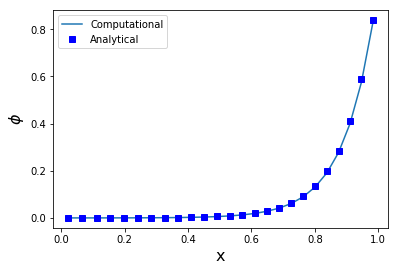

In [49]:
none, none = solve(25,"central","tdma",1)

Now for the convective terms using upwinding

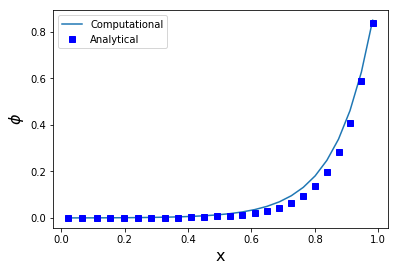

In [50]:
none, none = solve(25,"upwind","tdma",1)

## Grid Convergence Study
Perform a quantitative analysis of the error. Using multiple grids and compare the L2 norm reduction. 

In [51]:
# set up a sequence of grids
ngrids = 5
n = [32,64,128,256,512]
delta = np.zeros(ngrids)
l2_upwind = np.zeros(ngrids)
l2_central = np.zeros(ngrids)
nr = np.array(n, dtype=np.float64)  # make this real for plotting

# perform the simulations on each grid with different FD schemes
for ig in range(ngrids):
    delta[ig],l2_upwind[ig] = solve(n[ig],"upwind","tdma",0)
    delta[ig],l2_central[ig] = solve(n[ig],"central","tdma",0)
    print "Grid ",ig," Delta = ",delta[ig]," Error =",l2_upwind[ig],l2_central[ig]

Grid  0  Delta =  0.03125  Error = 0.0198341497198 0.00263133522343
Grid  1  Delta =  0.015625  Error = 0.00983581505771 0.000578097645079
Grid  2  Delta =  0.0078125  Error = 0.00429409999723 9.97159034618e-05
Grid  3  Delta =  0.00390625  Error = 0.00160913867356 1.51375420541e-05
Grid  4  Delta =  0.001953125  Error = 0.000709134041546 5.21634990657e-06


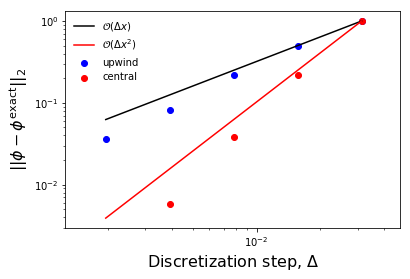

In [52]:
# plot the classical convergence diagram with first & second order slopes
pl.clf()
pl.scatter(delta, l2_upwind/l2_upwind[0],color="b", label="upwind")
pl.scatter(delta, l2_central/l2_central[0],color="r", label="central")
pl.plot(delta,(delta/delta[0]),color="k",label=r"$\mathcal{O}(\Delta x)$")
pl.plot(delta,((delta/delta[0])**2),color="r",label=r"$\mathcal{O}(\Delta x^2)$")
ax = pl.gca()
ax.set_xscale('log')
ax.set_yscale('log')
pl.xlabel(r"Discretization step, $\Delta$",fontsize=16)
pl.ylabel(r"$\|| \phi - \phi^\mathrm{exact} \||_2$",fontsize=16)
pl.legend(frameon=False);

## Further work

Implement the exponential discretization scheme